In [26]:
import pandas as pd
import psycopg2
import pandas.io.sql as psql
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from langdetect import detect
import re
import emoji
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix

%matplotlib inline

In [27]:
geonames = pd.read_pickle("../../../../dosT/ffunes/geonames_parsed.pkl")

from math import radians, sin, cos, atan2, sqrt

def haversine_distance(lat1, lon1, lat2, lon2):
    radius = 6371 # km

    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2) * sin(dlat/2) + cos(radians(lat1)) \
        * cos(radians(lat2)) * sin(dlon/2) * sin(dlon/2)
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c

    return d

def determine_distance(row):
    predicted_lat = row['predicted_lat']
    predicted_lon = row['predicted_lon']
    real_lat = row['real_lat']
    real_long = row['real_lon']
    
    return haversine_distance(predicted_lat, predicted_lon, real_lat, real_long)

def get_difference_distance(predicted_place, real_place):
    df_prediction = pd.DataFrame({
        'predicted_place': predicted_place,
        'real_place': real_place
    }, dtype=float)
        
    df_prediction[['predicted_cities','predicted_countries']] = df_prediction.predicted_place.str.split(',', expand=True) 
    df_prediction[['real_cities','real_countries']] = df_prediction.real_place.str.split(',', expand=True) 
    
    del df_prediction['predicted_place']
    del df_prediction['real_place']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['predicted_cities', 'predicted_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    df_prediction.rename(columns={'latitude': 'predicted_lat', 'longitude': 'predicted_lon'}, inplace=True)
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction = pd.merge(
        left=df_prediction,
        right=geonames.loc[:,['alternatenames', 'country', 'latitude', 'longitude']],
        how='left',
        left_on=['real_cities', 'real_countries'],
        right_on=['alternatenames', 'country'],
        validate='m:1'
    )
    
    del df_prediction['alternatenames']
    del df_prediction['country']
    
    df_prediction.rename(columns={'latitude': 'real_lat', 'longitude': 'real_lon'}, inplace=True)
    
    #print(df_prediction.head(5))
    
    print("Total NaN: ", df_prediction.shape[0]-df_prediction.dropna(subset=['real_lat', 'real_lon', 'predicted_lat', 'predicted_lon']).shape[0])

    return df_prediction.apply(determine_distance, axis=1)

In [3]:
try:
    conn = psycopg2.connect(user = "ffunes",
                            password = "location8",
                            host = "127.0.0.1",
                            port = "5432",
                            database = "elecciones_twitter")
except:
    print("No se pudo conectar a la base de datos")

In [ ]:
tweets_content = pd.read_sql_query(
    "SELECT id, full_text FROM tweets WHERE place_bounding_box IS NOT NULL limit 18000000"
    , con=conn 
)

In [4]:
tweets_content = pd.read_csv("../ids_located_tweets.csv")

In [5]:
tweets_content.shape

(17523907, 2)

In [6]:
tweets_content.head()

,id,full_text
0,1167775460916387842,No te pierdas esta noticia Todo lo que tenés q...
1,1167137433814568960,Photographs of the throat of the devil.\nmisio...
2,1167878558208819200,"UK, población 66 millones, encuentran que una ..."
3,1167868758108454913,“ La vergüenza se ha de poner de moda y fuera ...
4,1167763977696399360,@LanzadeCuba @CubaDami Gracias mi hermano!


In [7]:
usecols = [
    "id",
    "user_id"
]

In [ ]:
tweets_with_geo_and_city = pd.read_pickle('../../../../dosT/ffunes/tweets_with_geolocalization_geonames.pkl')

In [ ]:
tweets_with_geo_and_city = tweets_with_geo_and_city.loc[:, usecols]

In [ ]:
tweets_content = pd.merge(
    left=tweets_content,
    right=tweets_with_geo_and_city,
    how='inner',
    left_on=["id"],
    right_on=["id"],
    validate="1:1"     
)

In [ ]:
tweets_content = tweets_content.loc[:, ["full_text", "user_id"]]

In [ ]:
users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed.pkl")

In [39]:
users = pd.merge(
    left=users,
    right=tweets_content,
    how='inner',
    left_on=["id"],
    right_on=["user_id"],
    validate="1:m" 
)

del users["user_id"]

In [41]:
users.to_pickle("../../../../dosT/ffunes/total_users_parsed_with_content.pkl")

# Procesamos el contenido de los tweets de los usuarios

In [28]:
users = pd.read_pickle("../../../../dosT/ffunes/total_users_parsed_with_content.pkl")

In [29]:
tweet_counts = users.loc[:,['id', 'full_text']].\
    groupby('id').count()

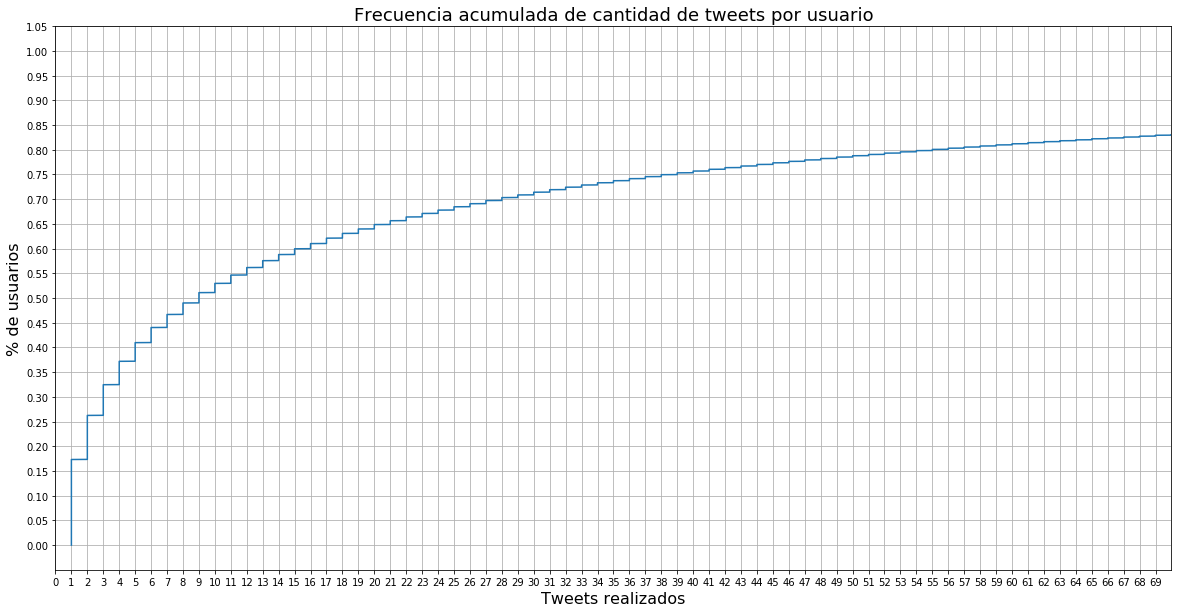

In [30]:
ecdf = ECDF(tweet_counts["full_text"])

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Tweets realizados", fontsize=16)
plt.ylabel("% de usuarios", fontsize=16)
plt.title("Frecuencia acumulada de cantidad de tweets por usuario", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.05))
plt.xticks(np.arange(0,70,1))
plt.xlim(0, 70)
#plt.hlines(accuracy_score(y_test[:, 0], y_predicted_city), -200, 1000, colors='r', linestyles='dashed')
#plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

In [31]:
users.head()

,id,is_private,favourites_count,followers_count,friends_count,listed_count,statuses_count,location,support,screen_name,...,important,place_type,place_name,place_country,latitude,longitude,detected_location,profile_city,profile_country,full_text
0,773970163502870528,False,974.0,68.0,312.0,0.0,647.0,"guadalajara de buga, colombia",frentedetodos,TaliaRada,...,False,city,guadalajara de buga,colombia,3.90089,-76.297829,Ubicacion exacta,"[{'place': 'guadalajara de buga', 'latitude': ...",colombia,https://t.co/QazR1cJSCS
1,773970163502870528,False,974.0,68.0,312.0,0.0,647.0,"guadalajara de buga, colombia",frentedetodos,TaliaRada,...,False,city,guadalajara de buga,colombia,3.90089,-76.297829,Ubicacion exacta,"[{'place': 'guadalajara de buga', 'latitude': ...",colombia,💁🏻‍♀️ A propósito del 8 de Marzo 👉 ¡Hablaremos...
2,773970163502870528,False,974.0,68.0,312.0,0.0,647.0,"guadalajara de buga, colombia",frentedetodos,TaliaRada,...,False,city,guadalajara de buga,colombia,3.90089,-76.297829,Ubicacion exacta,"[{'place': 'guadalajara de buga', 'latitude': ...",colombia,¿Por qué protestan los maestros? 👩‍🏫\nSintoníz...
3,77573705,False,1812.0,314.0,429.0,6.0,7271.0,"quito, ecuador",juntosporelcambio,jjaltamirano1,...,False,city,quito,ecuador,-0.22985,-78.524948,Ubicacion exacta,"[{'place': 'quito', 'latitude': -0.22984999418...",ecuador,Lamentable 😓.! Fuerza a su familia.. Dios lo t...
4,77573705,False,1812.0,314.0,429.0,6.0,7271.0,"quito, ecuador",juntosporelcambio,jjaltamirano1,...,False,city,quito,ecuador,-0.22985,-78.524948,Ubicacion exacta,"[{'place': 'quito', 'latitude': -0.22984999418...",ecuador,🥰❤️.! https://t.co/UTXtTt5HI4


In [32]:
usecols = [
    "id",
    "place_name",
    "place_country",
    "latitude",
    "longitude",
    "full_text"
]

In [33]:
users = users.loc[:, usecols]

In [34]:
users.head()

,id,place_name,place_country,latitude,longitude,full_text
0,773970163502870528,guadalajara de buga,colombia,3.90089,-76.297829,https://t.co/QazR1cJSCS
1,773970163502870528,guadalajara de buga,colombia,3.90089,-76.297829,💁🏻‍♀️ A propósito del 8 de Marzo 👉 ¡Hablaremos...
2,773970163502870528,guadalajara de buga,colombia,3.90089,-76.297829,¿Por qué protestan los maestros? 👩‍🏫\nSintoníz...
3,77573705,quito,ecuador,-0.22985,-78.524948,Lamentable 😓.! Fuerza a su familia.. Dios lo t...
4,77573705,quito,ecuador,-0.22985,-78.524948,🥰❤️.! https://t.co/UTXtTt5HI4


In [35]:
users_with_text = users.groupby(
        ["id", "place_name", "place_country", "latitude", "longitude"]
    )['full_text'].apply(list).reset_index(name='full_text')

In [36]:
users_with_text.shape

(176029, 6)

In [37]:
users_with_text.head()

,id,place_name,place_country,latitude,longitude,full_text
0,1059,guernica,argentina,-34.916199,-58.381111,"[Noche de limpieza facial 😊😊 en Guernica, Buen..."
1,1081,boston,estados unidos,34.025379,-87.758362,[i’m sure this won’t end in tears. 😂😥 https://...
2,2677,lenox,estados unidos,42.356480,-73.284828,[@YachtRockSXM where can I find a list of the ...
3,48093,berkeley,estados unidos,33.894272,-83.955742,"[@briancollins1 https://t.co/nNwvr1fnuR, Pairs..."
4,50963,leesburg,estados unidos,34.179821,-85.761360,[@peterwride Fun game to watch. Still weird we...


In [13]:
# Languages supported by NLTK

print(" ".join(SnowballStemmer.languages))

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [38]:
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [39]:
replacements = [
    #r'@\w+',
    #r'#\w+',
    r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',
    r'[.,!$%^&*]',
]

language_replacement = {
    "es": "spanish",
    "en": "english",
    "pt": "portuguese",
    "it": "italian",
    "fr": "french",
    "de": "german"
}

def parse_tweet(tweet):
    try:
        for replacement in replacements:
            tweet = re.sub(replacement, '', tweet)   

        tweet = re.sub(emoji.get_emoji_regexp(), '', tweet)
        tweet = re.sub(r'\r\n?|\n', ' ', tweet)

        return tweet
    except:
        return tweet
    
def stemming(tweet):
    try:
        lang = detect(tweet)
        
        stemmer = SnowballStemmer(language_replacement[lang])
        
        words_from_tweet = list(filter(None, tweet.split(' ')))
                
        return ' '.join(list(map(lambda x: stemmer.stem(x), words_from_tweet)))
    except:
        # No pudimos detectar el lenguaje ¿Es la mejor opción? -> Ej: hahahahahahaha ¿Considerar textos asi?
        return tweet    

def parse_and_stemming(row):
    tweets = row["full_text"]
    
    global total
    global users_processed
    
    users_processed += 1
    
    update_progress(users_processed / total)
    
    return list(map(lambda tweet: stemming(parse_tweet(tweet)), tweets))

def simple_parse(row):
    tweets = row["full_text"]
    
    global total
    global users_processed
    
    users_processed += 1
    
    update_progress(users_processed / total)
    
    return list(map(lambda tweet: parse_tweet(tweet), tweets))

In [ ]:
total = users_with_text.shape[0]
users_processed = 0
users_with_text["full_text"] = users_with_text.apply(parse_and_stemming, axis=1)

Progress: [##########----------] 52.4%


Save users stemming

In [31]:
users_with_text.to_pickle("../../../../dosT/ffunes/total_users_content_stem_v2.pkl")

Training no parse

In [5]:
users_with_text["unified_place"] = users_with_text["place_name"] + ',' + users_with_text["place_country"]

In [6]:
min_determined_place = users_with_text.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

In [7]:
min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1200, :]

In [8]:
min_determined_place.shape

(23, 2)

In [9]:
users_train_selected = pd.merge(
    left=users_with_text,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

users_train_selected.shape

(79642, 7)

In [10]:
users_train_selected["full_text"] = users_train_selected["full_text"].apply(lambda l: list(map(str, l)))

In [11]:
users_train_final = users_train_selected.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [ ]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    min_df=20,
    max_df=0.4
    #vocabulary=total_users
)

vector_of_words = vectorizer.fit_transform(users_train_final["full_text"].apply(lambda x: ' '.join(x))).astype('int')
vector_of_words

Normal results

In [41]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_words, users_complete_location[:,0], test_size=0.30)

In [42]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [43]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'class_weight': 'balanced', 'min_samples_leaf': 1, 'max_depth': 200} 0.48553345128984604


In [44]:
y_predicted = grid_drop.predict(X_test)

In [45]:
accuracy_score(y_test, y_predicted)

0.48436780647051436

In [46]:
balanced_accuracy_score(y_test, y_predicted)

0.39166927073136293

In [47]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


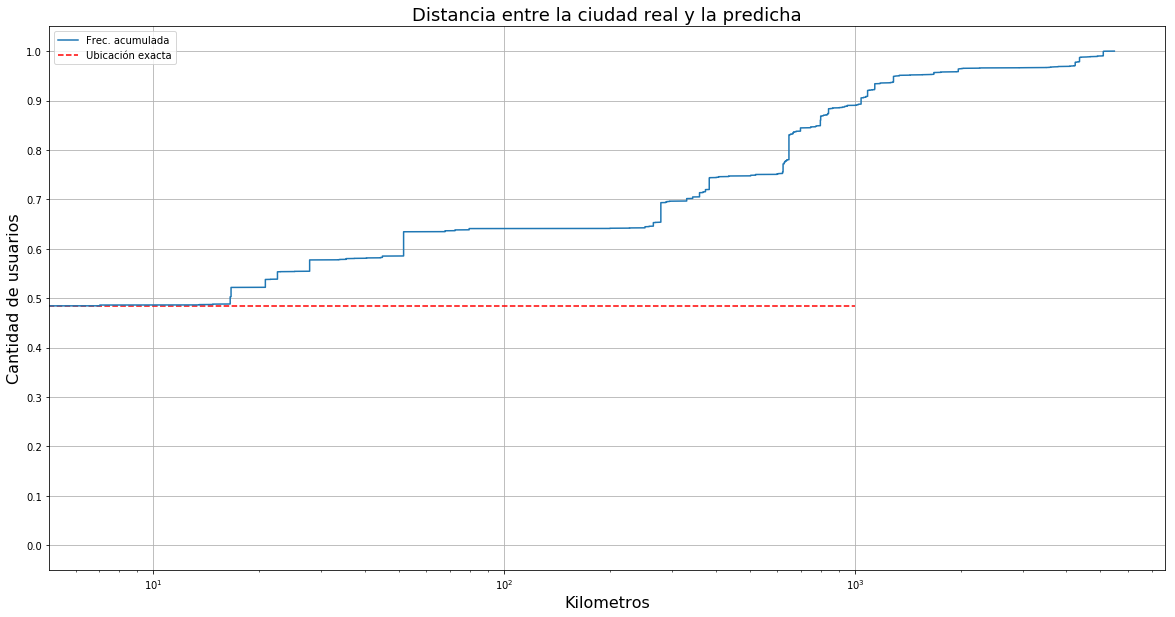

In [48]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

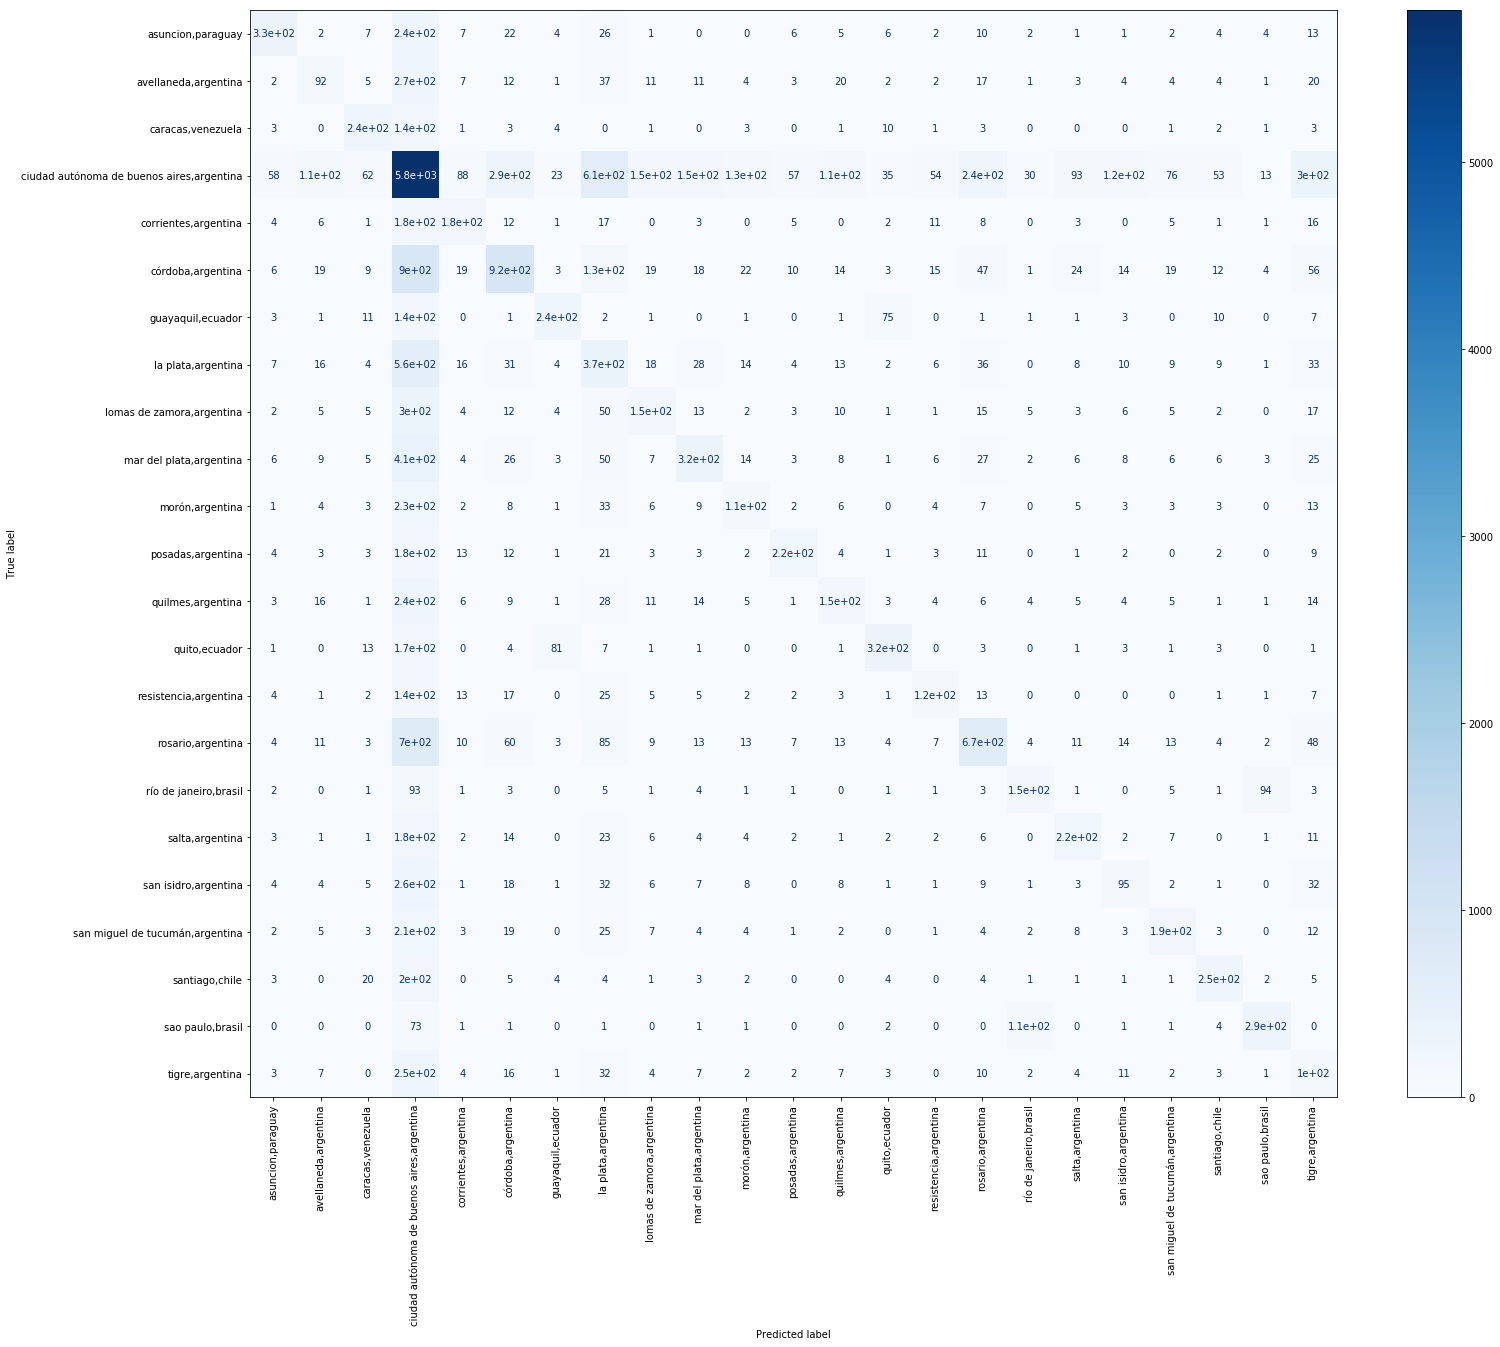

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Training with parse

In [40]:
users_with_text["unified_place"] = users_with_text["place_name"] + ',' + users_with_text["place_country"]

In [41]:
min_determined_place = users_with_text.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1200, :]

min_determined_place.shape

(23, 2)

In [42]:
users_train_selected = pd.merge(
    left=users_with_text,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

users_train_selected.shape

(79642, 7)

In [43]:
total = users_train_selected.shape[0]
users_processed = 0
users_train_selected["full_text"] = users_train_selected.apply(simple_parse, axis=1)

Progress: [####################] 100.0%


In [16]:
users_train_selected["full_text"] = users_train_selected["full_text"].apply(lambda l: list(map(str, l)))

users_train_final = users_train_selected.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [17]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    min_df=20,
    max_df=0.4
    #vocabulary=total_users
)

vector_of_words = vectorizer.fit_transform(users_train_final["full_text"].apply(lambda x: ' '.join(x))).astype('int')
vector_of_words

<79642x68397 sparse matrix of type '<class 'numpy.int64'>'
	with 20562419 stored elements in Compressed Sparse Row format>

In [19]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_words, users_complete_location[:,0], test_size=0.30)

In [20]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [21]:
param_grid= {'max_depth': [8, 80, 200, 500, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)

y_predicted = grid_drop.predict(X_test)

print(
    "Best params: ",  grid_drop.best_params_,
    "\nAccuracy training: ", grid_drop.best_score_,
    "\nAccuracy test: ", accuracy_score(y_test, y_predicted),
    "\nBalanced accuracy test: ", balanced_accuracy_score(y_test, y_predicted)
)

Best params:  {'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'} 
Accuracy training:  0.3875406034927623 
Accuracy test:  0.3883982756455866 
Balanced accuracy test:  0.36607518687094837


Best params:  {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1} 
Accuracy training:  0.3858365080903715 
Accuracy test:  0.3941740258653162 
Balanced accuracy test:  0.3646346943149593


In [22]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


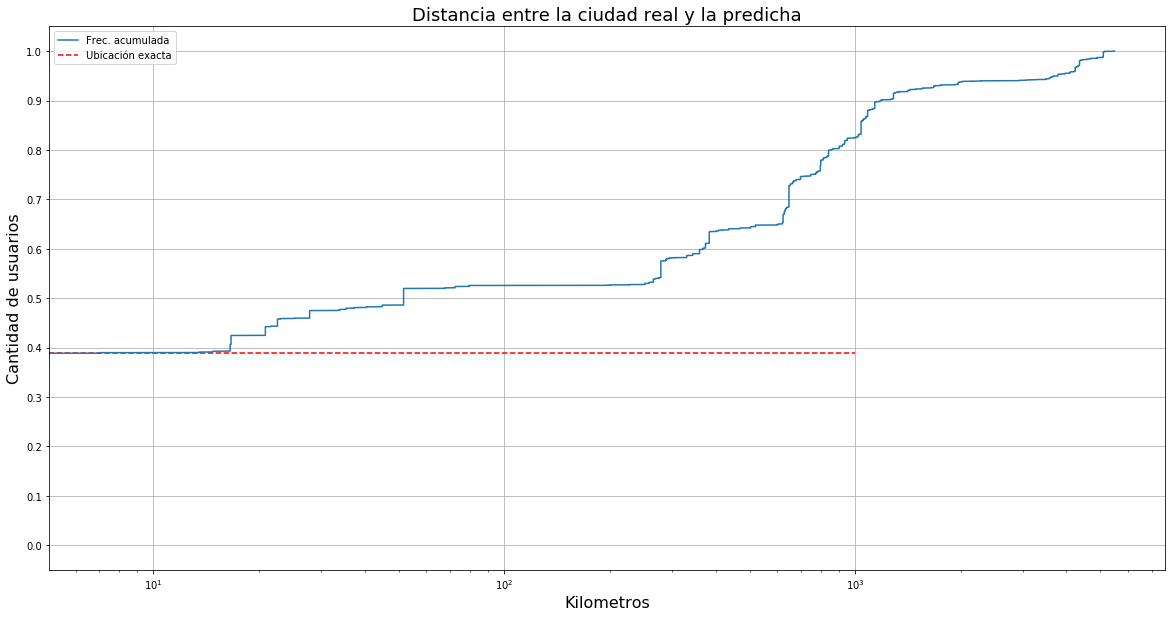

In [23]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

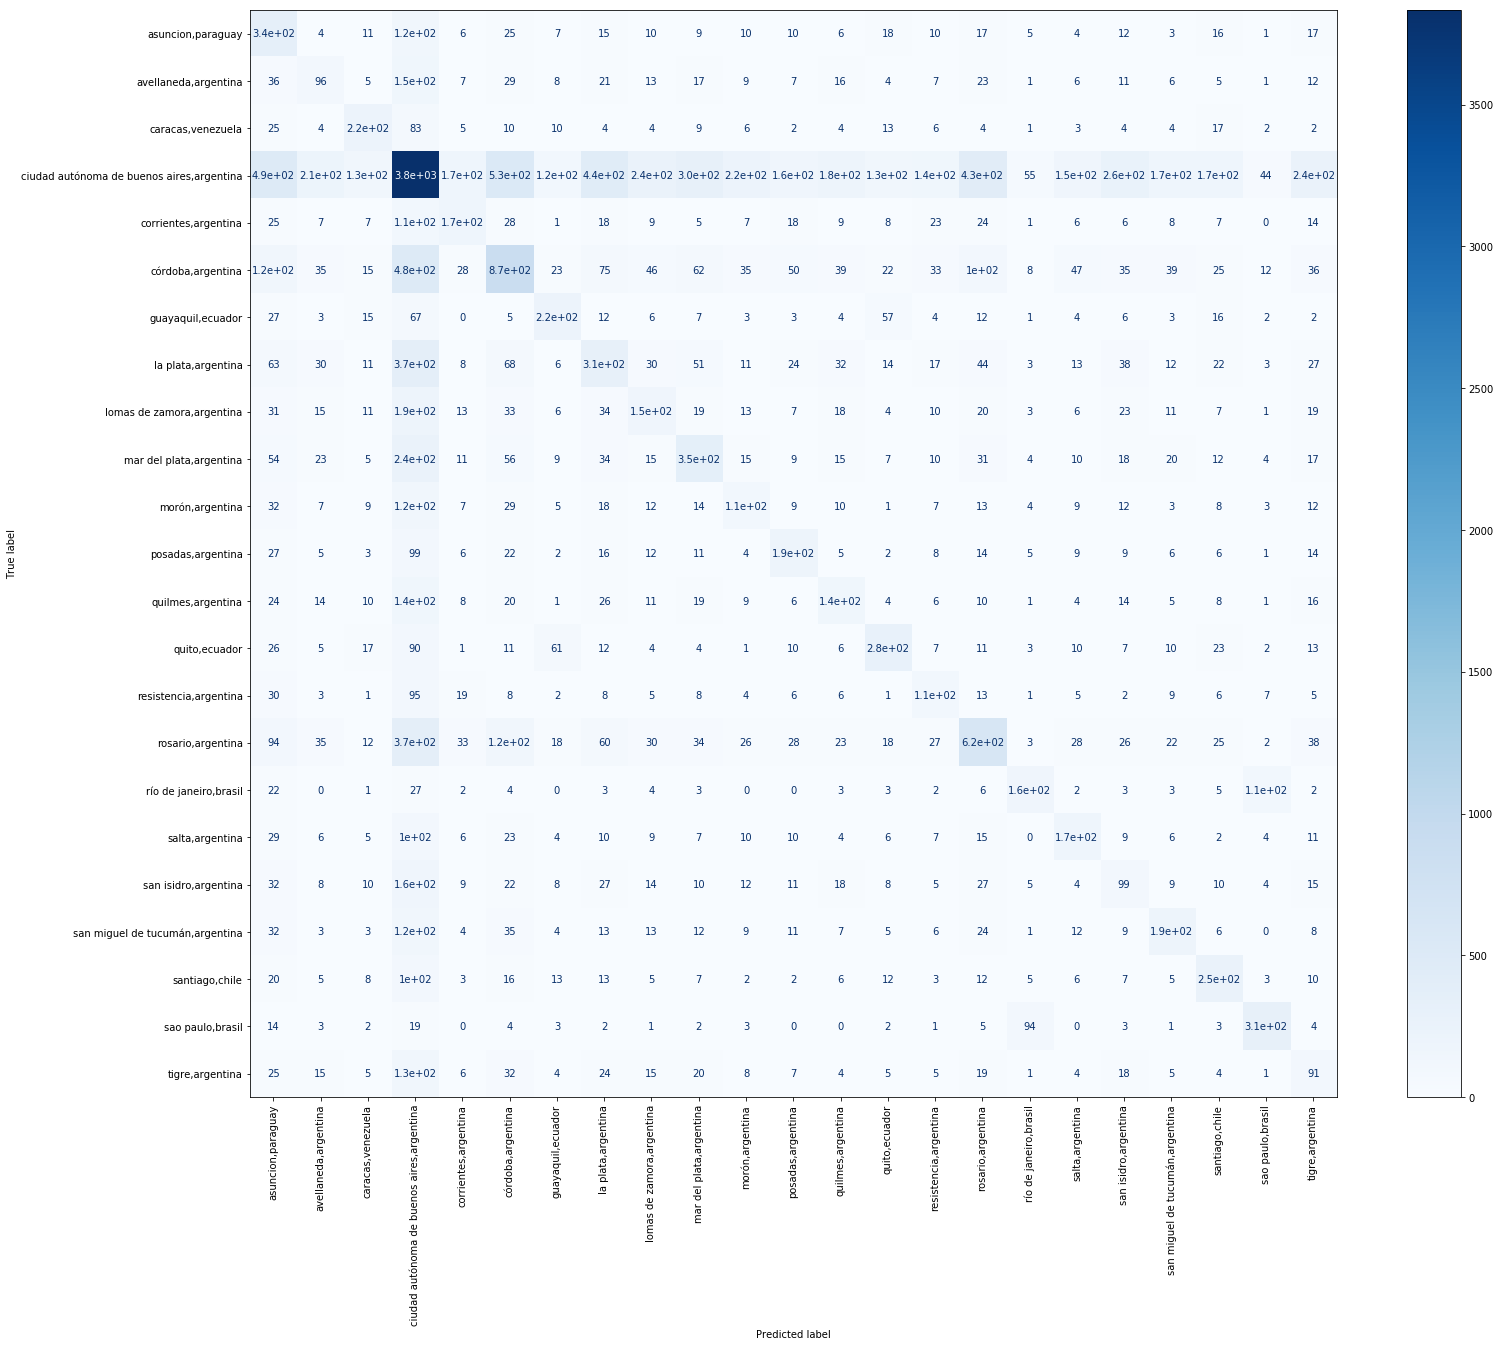

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)

Stemming results

In [50]:
users_with_text = pd.read_pickle("../../../../dosT/ffunes/total_users_content_stem.pkl")

In [51]:
users_with_text["unified_place"] = users_with_text["place_name"] + ',' + users_with_text["place_country"]

In [52]:
min_determined_place = users_with_text.loc[:, ["id", "unified_place"]].groupby("unified_place").count().sort_values('id', ascending=False).reset_index()

min_determined_place = min_determined_place.loc[min_determined_place["id"] >= 1200, :]

min_determined_place.shape

(23, 2)

In [53]:
users_train_selected = pd.merge(
    left=users_with_text,
    right=min_determined_place.loc[:, ['unified_place']],
    how='inner',
    left_on='unified_place',
    right_on='unified_place',
    validate='m:1'
)

users_train_selected.shape

(79642, 7)

In [54]:
users_train_selected["full_text"] = users_train_selected["full_text"].apply(lambda l: list(map(str, l)))

users_train_final = users_train_selected.sample(frac=1, random_state=4503493)
users_complete_location = users_train_final.loc[:, ["unified_place", "latitude", "longitude"]].values
class_names = sorted(users_train_final['unified_place'].unique())

In [55]:
vectorizer = CountVectorizer(
    strip_accents="ascii",
    lowercase=True,
    min_df=20,
    max_df=0.4
    #vocabulary=total_users
)

vector_of_words = vectorizer.fit_transform(users_train_final["full_text"].apply(lambda x: ' '.join(x))).astype('int')
vector_of_words

<79642x46368 sparse matrix of type '<class 'numpy.int64'>'
	with 17774603 stored elements in Compressed Sparse Row format>

In [11]:
users_train_final["full_text"]

4634     [@pinonfijo1 Sos un crack Piñon!!, @dhh Moto E...
12532    [Clases con @proyectodanzaya \n.\n#Bailá #Bail...
15859    [Sé que algunas piezas no encajarán jamás, te ...
74257    [Domingo con Ustedes lo tengo todo!! ❤️ en Pla...
18941    [@kiss @TheKISSKruise Ya tengo las entradas pa...
10263    [@A24COM @Kicillofok Durante su gobierno ya ve...
36342    [Me capturaron siendo felí en Los Infernales d...
14430    [@ArnetOnline nos pueden informar acerca de la...
71538    [Decime donde que allá voy...\n\nEsa cara de f...
53297    [Todo de la cabeza haciendo descontrol ❤️ en E...
41913    [📍Lo que más necesitamos muchas mujeres es apr...
42670    [Tener una relación conmigo es difícil, porque...
20535    [𝓛𝓪 𝓬𝓲𝓾𝓭𝓪𝓭 𝓶𝓪́𝓼 𝓫𝓸𝓷𝓲𝓽𝓪 ✨ en Ciudad Autónoma de...
56594    [Parte del familion Soublette Castro, dando x ...
62034    [Junto a @josecorralsf compartimos la convicci...
58015                 [@MiminLaLoca Te escribi al privado]
54980    [🎬+ 🍕 Hoy el cine es una buena excusa para hac.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(vector_of_words, users_complete_location[:,0], test_size=0.30)

In [10]:
decisiontree = DecisionTreeClassifier()
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [60]:
param_grid= {'max_depth': [8, 80, 200, None], 'min_samples_leaf': [1],
             'class_weight': ['balanced']}
grid_drop = GridSearchCV(decisiontree, param_grid, cv=5, scoring='accuracy')
grid_drop.fit(X_train, y_train)
print(grid_drop.best_params_, grid_drop.best_score_)

{'class_weight': 'balanced', 'min_samples_leaf': 1, 'max_depth': None} 0.3737644454830552


In [61]:
y_predicted = grid_drop.predict(X_test)

In [62]:
accuracy_score(y_test, y_predicted)

0.3763026827941238

In [63]:
balanced_accuracy_score(y_test, y_predicted)

0.34620020071844193

In [64]:
distances_predicted = get_difference_distance(
    y_predicted,
    y_test
)

Total NaN:  0


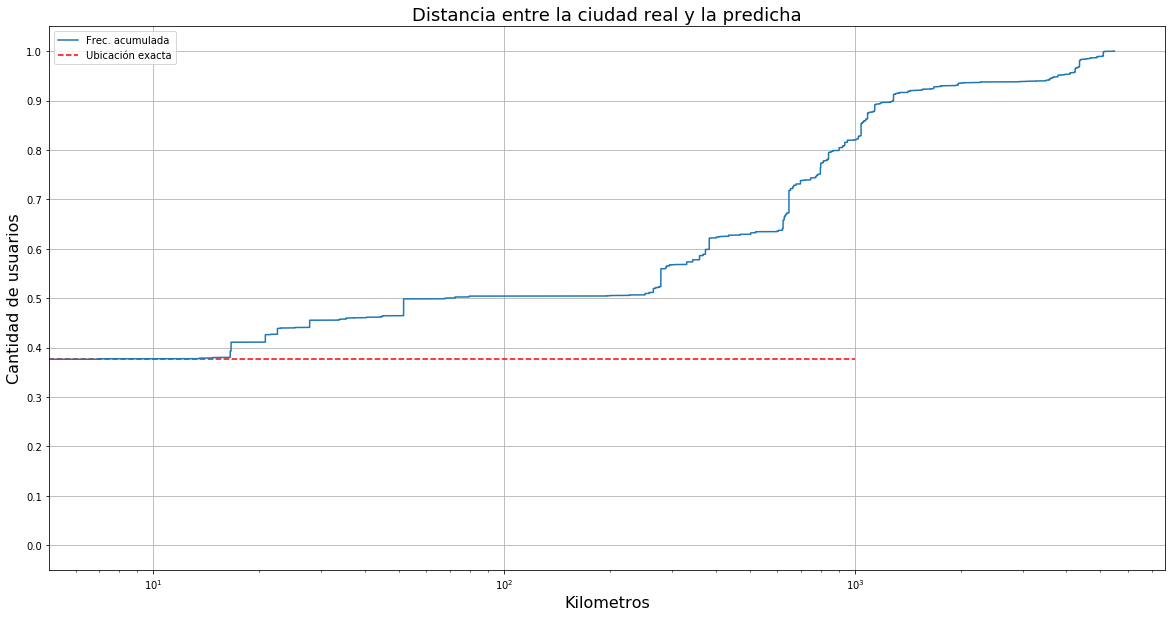

In [65]:
ecdf = ECDF(distances_predicted)

plt.figure(figsize=(20,10)) 
plt.grid(b=True, which='major')
plt.xlabel("Kilometros", fontsize=16)
plt.ylabel("Cantidad de usuarios", fontsize=16)
plt.title("Distancia entre la ciudad real y la predicha", fontsize=18)
plt.plot(ecdf.x,ecdf.y)
plt.yticks(np.arange(0,1.1,0.1))
#plt.x
#plt.xticks(np.arange(0,1000,50))
plt.xscale('log')
plt.hlines(accuracy_score(y_test, y_predicted), -200, 1000, colors='r', linestyles='dashed')
plt.legend(["Frec. acumulada", "Ubicación exacta"])
plt.show()

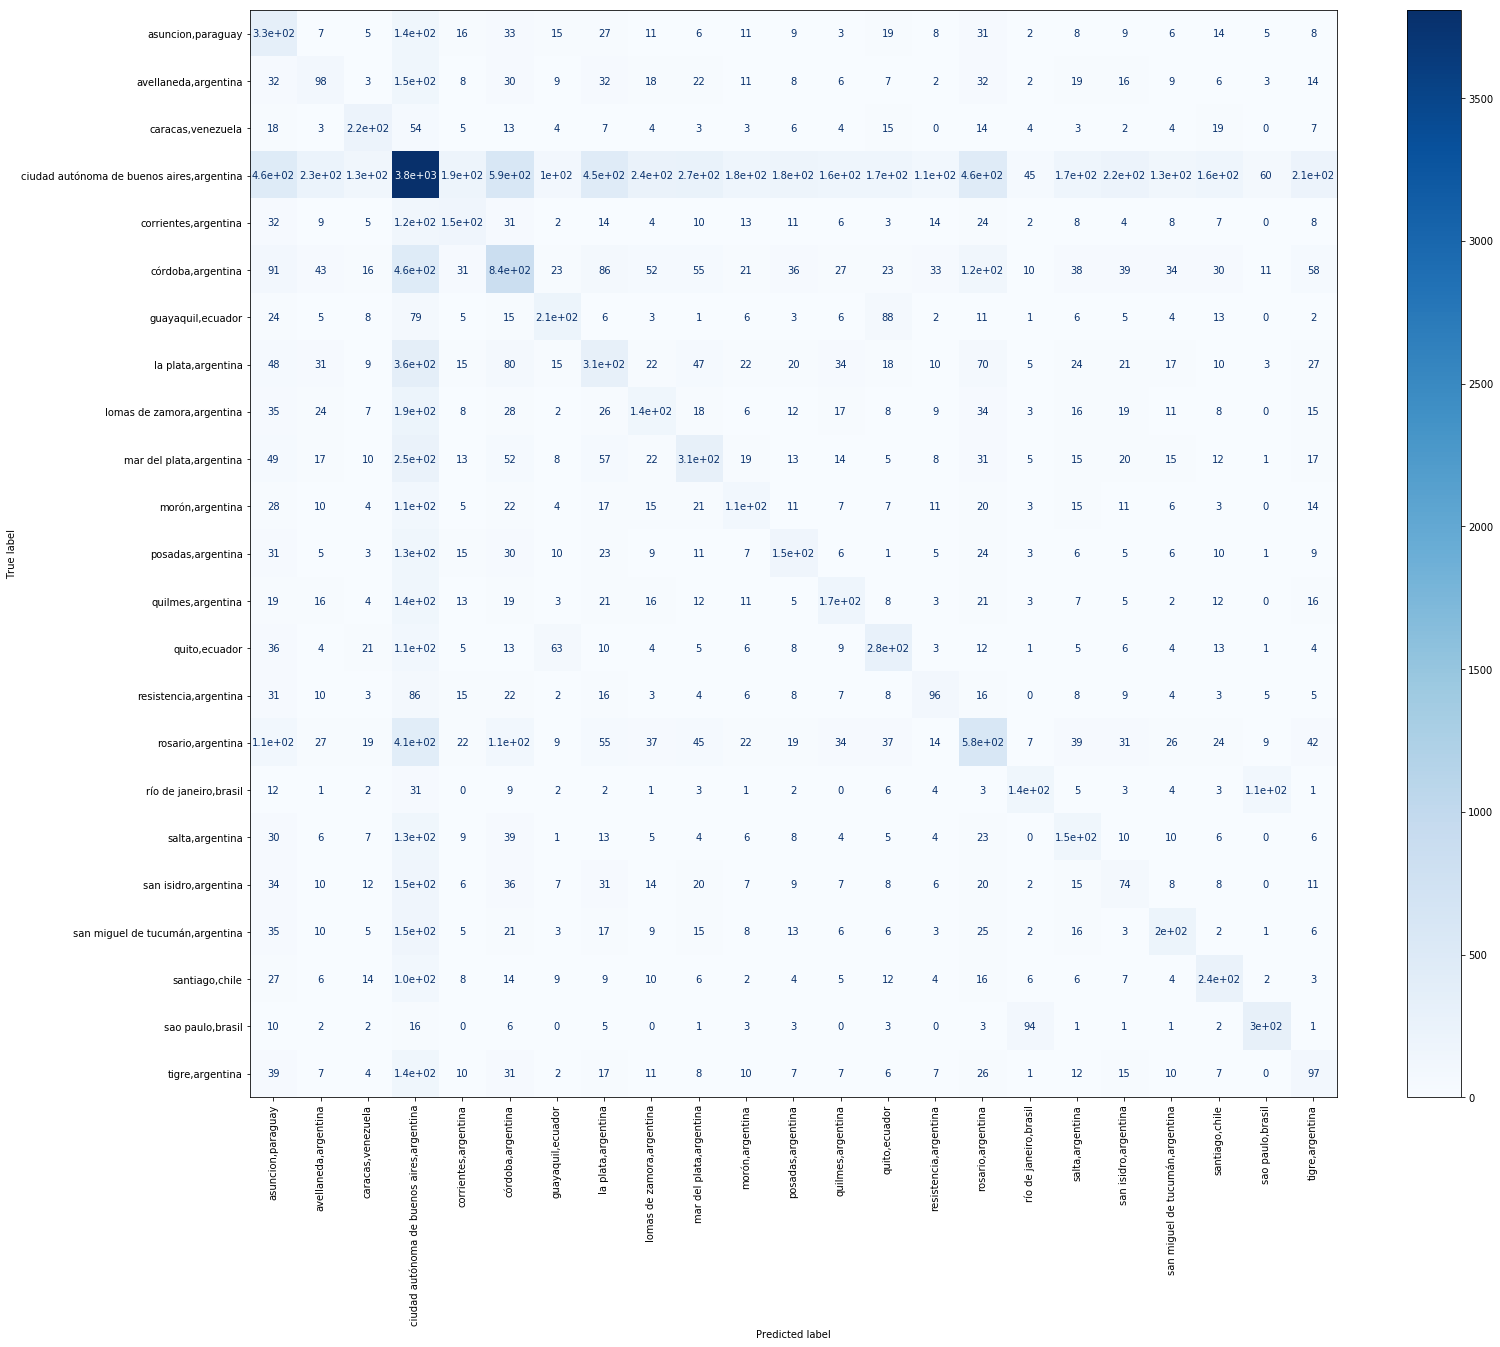

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 20)
disp = plot_confusion_matrix(grid_drop.best_estimator_, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None,
                                xticks_rotation='vertical',
                            ax=ax)